In [1]:
import xarray as xr
import rasterio
import geopandas as gpd
import rasterstats as rstats
import numpy as np
import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt

## Load data

In [2]:
shp_fo = '../urban_greening/msa/michiganMSA_reprojected.shp'
shp_df = gpd.read_file(shp_fo, encoding='ISO-8859-1')
shp_df = shp_df[shp_df['LSAD']=='M1']

In [9]:
landcover_path = "../urban_greening/gis_processed/nlcd/nlcdmi2.tif"
# landcover_path = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
landcover_ds = rasterio.open(landcover_path)

In [23]:
landcover_data = landcover_ds.read(1)

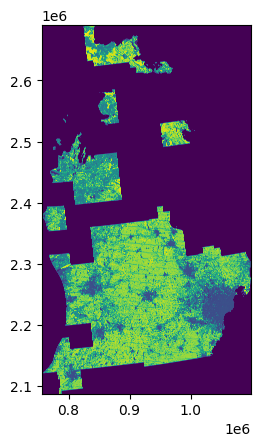

<Axes: >

In [10]:
import rasterio.plot

rasterio.plot.show(landcover_ds)

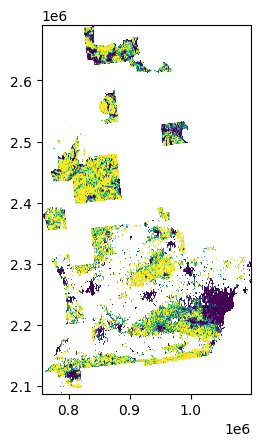

<Axes: >

In [13]:
gpp_path = "../urban_greening/gis_processed/modis/modtestmi.tif"
# gpp_path = "../urban_greening/gis_processed/modis/modis2015_rep_res.tif"
gpp_ds = rasterio.open(gpp_path)
rasterio.plot.show(gpp_ds)

In [16]:
# with rasterio.open(gpp_path) as src:
#     resampled_gpp = src.read(1)
# resampled_gpp.shape

(20168, 11408)

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [74]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import numpy as np

target = landcover_ds
target_width = target.meta['width']
target_height = target.meta['height']
target_resolution = target.transform[0]
print(target_width, target_height, target_resolution)

# Desired new resolution (e.g., 30x30 meters)
new_resolution = (target_resolution, target_resolution)

# make gpp has same weight and height as nlcd
with rasterio.open(gpp_path) as src:
    # Calculate the transform and dimensions for the new resolution
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height,
        src.bounds.left, src.bounds.bottom,
        src.bounds.right, src.bounds.top,
        dst_width=target_width,
        dst_height=target_height
    )

    # Create an empty array to hold the resampled data
    resampled_gpp = np.empty((height, width), dtype=src.meta['dtype'])

    # Resample each band and store it in the array
    reproject(
        source=rasterio.band(src, 1),
        destination=resampled_gpp,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target.transform,
        dst_crs=target.crs,
        resampling=Resampling.bilinear  # Use your desired resampling method
    )

print(resampled_gpp.shape)

11409 20168 30.0
(20168, 11409)


In [19]:
ua_path = "../urban_greening/gis_processed/ua/ua_30.tif"
ua_ds = rasterio.open(ua_path)
ua_data = ua_ds.read(1)

In [75]:
# make ua has same weight and height as nlcd
with rasterio.open(ua_path) as src:
    # Calculate the transform and dimensions for the new resolution
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height,
        src.bounds.left, src.bounds.bottom,
        src.bounds.right, src.bounds.top,
        dst_width=target_width,
        dst_height=target_height
    )

    # Create an empty array to hold the resampled data
    ua_data = np.empty((height, width), dtype=src.meta['dtype'])

    # Resample each band and store it in the array
    reproject(
        source=rasterio.band(src, 1),
        destination=ua_data,
         rc_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target.transform,
        dst_crs=target.crs,
        resampling=Resampling.nearest  # Use your desired resampling method
    )

print(ua_data.shape)

(20168, 11409)


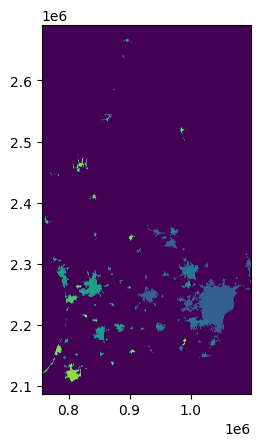

<Axes: >

In [76]:
rasterio.plot.show(ua_ds)

In [77]:
# see if the width and height are same
print(ua_data.shape)
print(landcover_data.shape)
print(resampled_gpp.shape)

(20168, 11409)
(20168, 11409)
(20168, 11409)


## Process data

In [78]:
valid_gpp_mask = (resampled_gpp >= 0) # after resample  negative value means there is no data, instead of 65535 means no data
urban_mask = (ua_data != 0)
suburban_mask = (ua_data == 0)
forest_mask = (landcover_data == 41) | (landcover_data == 42) | (landcover_data == 43)
shrub_mask = (landcover_data == 51) | (landcover_data == 52)

mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask
}

In [79]:
urban_forest_filtered_gpp = np.where(valid_gpp_mask & mask_dict['urban_forest'], resampled_gpp, np.nan)
suburban_forest_filtered_gpp = np.where(valid_gpp_mask & mask_dict['suburban_forest'], resampled_gpp, np.nan)
urban_shrub_filtered_gpp = np.where(valid_gpp_mask & mask_dict['urban_shrub'], resampled_gpp, np.nan)
suburban_shrub_filtered_gpp = np.where(valid_gpp_mask & mask_dict['suburban_shrub'], resampled_gpp, np.nan)

In [97]:
x = np.unique(urban_forest_filtered_gpp)

In [104]:
np.unique(np.where(valid_gpp_mask & forest_mask & urban_mask, resampled_gpp, np.nan))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       nan])

In [100]:
x[1] == 1.0

np.True_

In [81]:
filtered_gpp_dict = {
    'urban_forest': urban_forest_filtered_gpp,
    'suburban_forest': suburban_forest_filtered_gpp,
    'urban_shrub': urban_shrub_filtered_gpp,
    'suburban_shrub': suburban_shrub_filtered_gpp
}

In [82]:
transform = landcover_ds.transform

In [83]:
landcover_ds.transform

Affine(30.0, 0.0, 756105.0,
       0.0, -30.0, 2691615.0)

In [88]:
gpp_ds.transform

Affine(30.00000000000002, 0.0, 756109.1188588343,
       0.0, -30.000000000000046, 2691619.4366572294)

## calcuate and gap-fill gpp

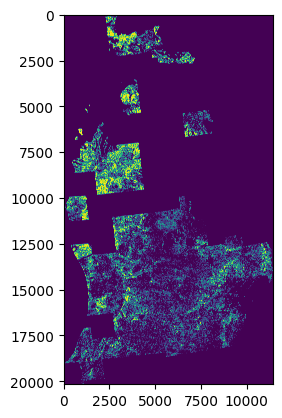

In [ ]:
plt.imshow(forest_mask)

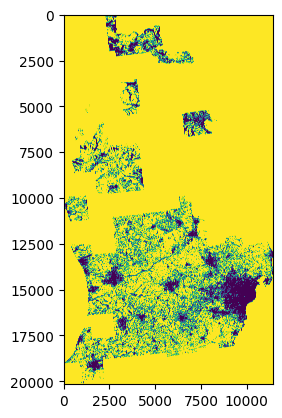

<Axes: >

In [105]:
rasterio.plot.show(valid_gpp_mask)

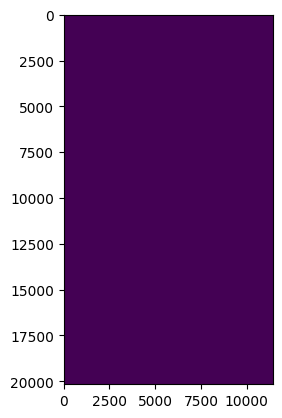

<Axes: >

In [117]:

rasterio.plot.show(resampled_gpp < 43)

In [106]:
valid_gpp_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

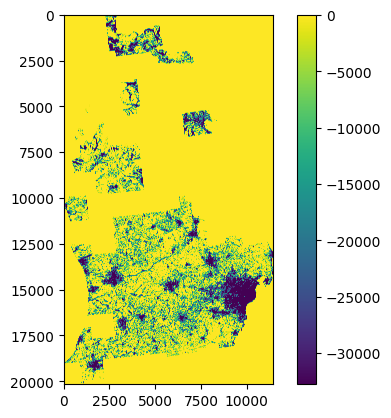

In [ ]:

test = np.copy(resampled_gpp)
# test[~valid_gpp_mask & forest_mask] = -2
plt.imshow(test)
plt.colorbar()

In [ ]:
from rasterio.features import geometry_mask
import rasterstats

gpp_filled = np.copy(resampled_gpp)

category_gpp_mean_list = []

for _, feature in shp_df[:2].iterrows():
    print(feature['NAME'])
    record = {'name': feature['NAME']}

    for category, landcover_mask in mask_dict.items():
        geometry = [feature['geometry']]

        # calculate mean gpp value for category
        category_gpp_mean = rasterstats.zonal_stats(geometry, filtered_gpp_dict[category], affine=transform, stats="mean", nodata=np.nan)[0]['mean']
        record[category] = category_gpp_mean
        # gpp_mean_vals[feature['NAME']][category] = mean_val
        # retrieve mean gpp value for category
        # category_gpp_mean = gpp_mean_vals[feature['NAME']][category]

        geometry_mask_array = geometry_mask(
            geometries=geometry,
            transform=transform, # resampled_gpp transform, same as landcover_ds
            invert=True,
            out_shape=gpp_filled.shape
        )

        gpp_filled[~valid_gpp_mask & landcover_mask & geometry_mask_array] = category_gpp_mean
        

    category_gpp_mean_list.append(record)

gpp_filled

Traverse City, MI
Jackson, MI
Detroit-Warren-Dearborn, MI
Monroe, MI
Ann Arbor, MI
Flint, MI
Grand Rapids-Wyoming-Kentwood, MI
Muskegon-Norton Shores, MI
Kalamazoo-Portage, MI
Battle Creek, MI
Lansing-East Lansing, MI
Saginaw, MI
Bay City, MI
Midland, MI
Niles, MI
South Bend-Mishawaka, IN-MI


array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int16)

In [60]:
pd.DataFrame(category_gpp_mean_list)

,name,urban_forest,suburban_forest,urban_shrub,suburban_shrub
0,"Traverse City, MI",0.008960,0.074545,0.009662,0.031656
1,"Jackson, MI",9.654934,7.462845,7.774194,8.270588
2,"Detroit-Warren-Dearborn, MI",6.108252,3.882899,5.330463,3.725143
3,"Monroe, MI",11.963755,9.008226,9.802469,8.942181
4,"Ann Arbor, MI",9.366459,8.019724,8.743750,7.117912
5,"Flint, MI",3.462235,4.672796,2.515625,4.533686
6,"Grand Rapids-Wyoming-Kentwood, MI",3.262953,3.493518,2.822598,3.847849
7,"Muskegon-Norton Shores, MI",3.867227,3.177907,4.284000,3.087811
8,"Kalamazoo-Portage, MI",5.904833,5.577639,5.607143,5.345019
9,"Battle Creek, MI",5.423365,5.766367,7.866667,5.878722


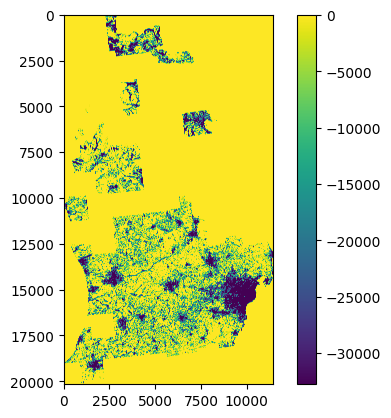

In [67]:


plt.imshow(gpp_filled)
plt.colorbar()

In [61]:
# write gap-filled gpp to raster
from rasterio.crs import CRS
output_tiff = "gpp_filled_mi_test.tif"

with rasterio.open(
    output_tiff,
    "w",
    driver="GTiff",
    height=gpp_filled.shape[0],
    width=gpp_filled.shape[1],
    count=1,  # Number of bands, assuming single-band for GPP
    dtype=gpp_filled.dtype,
    crs=landcover_ds.crs,  # Replace with the correct CRS if different
    transform=transform,
) as dst:
    dst.write(gpp_filled, 1)